In [29]:
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import pickle
import torch
from torchvision import datasets, transforms

In [30]:
os.chdir('/Users/gouse/PycharmProjects/AR-Imperial-Thesis')
os.getcwd()

'/Users/gouse/PycharmProjects/AR-Imperial-Thesis'

## Load the data

In [31]:
feature_names = ["thickness_small", "thickness_medium", "thickness_large", "thickness_xlarge",
                 "width_small", "width_medium", "width_large", "width_xlarge",
                 "length_small", "length_medium", "length_large", "length_xlarge"]

class_names = ["6", "8", "9"]

# mapping from feature index to feature name
feature_index_to_name = {i: feature_name for i, feature_name in enumerate(feature_names)}
# mapping from feature name to feature index
feature_name_to_index = {feature_name: i for i, feature_name in enumerate(feature_names)}
# mapping from class index to class name
class_index_to_name = {i: class_name for i, class_name in enumerate(class_names)}
# mapping from class name to class index
class_name_to_index = {class_name: i for i, class_name in enumerate(class_names)}

In [32]:
# Download training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

train_dataset = datasets.MNIST(root='./datasets/MNIST/data', train=True,
                               download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root='./datasets/MNIST/data', train=False,
                              download=True,
                              transform=transform)

dict_of_lists = {6: [], 8: [], 9: []}
for i, (_, label) in enumerate(train_dataset):
    if label in dict_of_lists.keys():
        dict_of_lists[label].append(
            train_dataset.data[i].reshape(1, 28, 28))

for key in dict_of_lists.keys():
    dict_of_lists[key] = np.vstack(dict_of_lists[key]).reshape(-1, 1,
                                                               28, 28)
    if key == 8:
        X = torch.cat((torch.tensor(dict_of_lists[6]),
                       torch.tensor(dict_of_lists[8])))
    elif key > 8:
        X = torch.cat((X, torch.tensor(dict_of_lists[key])))

# import pickle files
with open('./datasets/MNIST/mine_preprocessed/area_dict.pkl', 'rb') as f:
    area = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/length_dict.pkl', 'rb') as f:
    length = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/thickness_dict.pkl', 'rb') as f:
    thickness = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/slant_dict.pkl', 'rb') as f:
    slant = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/width_dict.pkl', 'rb') as f:
    width = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/height_dict.pkl', 'rb') as f:
    height = pickle.load(f)

# load the targets test
with open('./datasets/MNIST/mine_preprocessed/area_dict_test.pkl', 'rb') as f:
    area_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/length_dict_test.pkl', 'rb') as f:
    length_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/thickness_dict_test.pkl', 'rb') as f:
    thickness_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/slant_dict_test.pkl', 'rb') as f:
    slant_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/width_dict_test.pkl', 'rb') as f:
    width_test = pickle.load(f)
with open('./datasets/MNIST/mine_preprocessed/height_dict_test.pkl', 'rb') as f:
    height_test = pickle.load(f)

In [33]:
targets = []
digits_size = 0
labels = []
# for i in range(4,10):
for i in [6, 8, 9]:
    # targets += list(
    #     zip(thickness[i], width[i], slant[i], height[i]))
    targets += list(
        zip(thickness[i], width[i], length[i]))
    # targets += list(
    # zip(thickness[i], area[i], length[i],
    #                     width[i], height[i], slant[i]))
    if i == 6:
        k = 0
    elif i == 8:
        k = 1
    else:
        k = 2
    # labels.append([(i-4) for j in range(len(targets) - digits_size)])
    labels.append([k for j in range(len(targets) - digits_size)])
    digits_size += len(width[i])

targets = np.array(targets)

def assign_bins(data, bin_edges):
    return np.digitize(data, bins=bin_edges, right=True)

# Convert bin numbers to one-hot encoded values
def one_hot_encode(bin_numbers, num_bins):
    return np.eye(num_bins)[bin_numbers - 1]

def process_data(targets, num_bins=4):
    bins_data_all_indices = {}
    bins_data_all = []
    min_max_values_all = []
    closest_images_all = []
    bin_counts = []

    for i in range(targets.shape[1]):
        # Combine the data
        combined_data = list(targets[:, i])

        # Sort the combined data
        combined_sorted = np.sort(combined_data)

        # Determine the number of data points per bin
        bin_size = len(combined_sorted) // num_bins

        # Calculate bin edges
        bin_edges = [combined_sorted[i * bin_size] for i in range(1, num_bins)] + [combined_sorted[-1]]
        bin_edges = [-np.inf] + bin_edges

        # Assign bins to the original data lists
        bins_data = assign_bins(targets[:, i], bin_edges)

        # Do one-hot encoding in the bins
        bins_data_encoded = one_hot_encode(bins_data, num_bins)

        # Get min and max values per bin
        min_max_values = []
        closest_images = []
        counts = []

        feature_bins_data = {}

        for bin_num in range(1, num_bins + 1):
            bin_indices = np.where(bins_data == bin_num)[0]
            bin_values = targets[bin_indices, i]
            counts.append(len(bin_indices))

            if len(bin_values) > 0:
                min_val = np.min(bin_values)
                max_val = np.max(bin_values)
                min_max_values.append((min_val, max_val))

                # Select 5 images closest to the minimum and 5 closest to the maximum
                closest_min_indices = bin_indices[np.argsort(np.abs(bin_values - min_val))[:5]]
                closest_max_indices = bin_indices[np.argsort(np.abs(bin_values - max_val))[:5]]
                closest_images.append((closest_min_indices, closest_max_indices))
            else:
                min_max_values.append((None, None))
                closest_images.append(([], []))
                
            feature_bins_data[bin_num] = list(bin_indices)

        bins_data_all.append(bins_data_encoded)
        bins_data_all_indices[i] = feature_bins_data
        min_max_values_all.append(min_max_values)
        closest_images_all.append(closest_images)
        bin_counts.append(counts)

    return bins_data_all, bins_data_all_indices, min_max_values_all, closest_images_all, bin_counts

# Example usage:
#targets = np.random.randn(100, 2)  # Example targets with 2 features and 100 samples
num_bins = 4
bins_data_all, bins_data_all_indices, min_max_values_all, closest_images_all, bin_counts = process_data(targets, num_bins=num_bins)

# Output the results
for feature_idx in range(targets.shape[1]):
    print(f"Feature {feature_idx}")
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[feature_idx]):
        print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
        print(f"    Closest to Min: {closest_images_all[feature_idx][bin_idx][0]}")
        print(f"    Closest to Max: {closest_images_all[feature_idx][bin_idx][1]}")


Feature 0
  Bin 1: Min = 1.0608199852609512, Max = 2.0955714117145585
    Closest to Min: [ 5950  6513 16167  1617  8621]
    Closest to Max: [ 5724 15599 12669 15554 15557]
  Bin 2: Min = 2.095583355223437, Max = 2.455555185927587
    Closest to Min: [  157 11735  2878 11170  5908]
    Closest to Max: [10186    92 12276  7142 11892]
  Bin 3: Min = 2.455627281914512, Max = 2.901642846528742
    Closest to Min: [9156 6174 7889 4619 3771]
    Closest to Max: [  244   426  4118  5549 12352]
  Bin 4: Min = 2.9016807521673793, Max = 9.53389237525011
    Closest to Min: [17317  8534  9637 12831 12134]
    Closest to Max: [ 6880 11069  6466  8310 10537]
Feature 1
  Bin 1: Min = 5.381124287425585, Max = 10.939789083379203
    Closest to Min: [12129 10069  1848  2104  1426]
    Closest to Max: [  295 14518 15892 14841 10100]
  Bin 2: Min = 10.940738953737265, Max = 12.576095107156878
    Closest to Min: [11208  4297  6288  6421 12348]
    Closest to Max: [11690 16675 17656 10882 16855]
  Bin 3:

In [34]:
C = np.stack(bins_data_all, axis=1).reshape(-1, num_bins* targets.shape[1])
y = np.array([item for sublist in labels for item in sublist])
np.random.seed(42)

from sklearn.model_selection import train_test_split
# Split the data
def train_test_split_with_indices(*arrays, **options):
    # Extract the test_size and train_size parameters if they exist
    test_size = options.pop('test_size', None)
    train_size = options.pop('train_size', None)
    random_state = options.pop('random_state', None)
    shuffle = options.pop('shuffle', True)
    stratify = options.pop('stratify', None)
    indices = options.pop('indices', None)

    # Get the number of samples in the input arrays
    n_samples = arrays[0].shape[0]

    # Use provided indices or generate default indices
    if indices is None:
        indices = np.arange(n_samples)
    
    # Generate indices for the split
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, train_size=train_size, 
        random_state=random_state, shuffle=shuffle, stratify=stratify
    )

    # Split the arrays using the generated indices
    result = []
    for array in arrays:
        result.append(array[train_indices])
        result.append(array[test_indices])

    # Append the indices to the result
    result.append(train_indices)
    result.append(test_indices)

    return result

X_train, X_val, C_train, C_val, y_train, y_val, train_indices, val_indices = train_test_split_with_indices(X, C, y,
                                                                  test_size=0.5,
                                                                  random_state=42)

train_index_to_or_index = {i: original_idx for i, original_idx in enumerate(train_indices)}
train_or_index_to_index = {original_idx: i for i, original_idx in enumerate(train_indices)}

X_val, X_test, C_val, C_test, y_val, y_test, val_indices, test_indices = train_test_split_with_indices(X_val, C_val, y_val,
                                                                  test_size=0.5,
                                                                  random_state=42)
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
C_train = torch.tensor(C_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
C_val = torch.tensor(C_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
C_test = torch.tensor(C_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_5394/2629746947.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_5394/2629746947.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/var/folders/s6/pzn2mzln089b14702jlw7cqm0000gn/T/ipykernel_5394/2629746947.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


#### Load predictions per leaf

In [65]:
output_path = "/Users/gouse/PycharmProjects/AR-Imperial-Thesis/logs_and_models_to_show/analysis_notebooks/Leakage_Inspection_Case_Study/model/train_dicts"

In [66]:
with open(os.path.join(output_path, 'leaf_samples_indices.pkl'), 'rb') as f:
    leaf_samples_indices = pkl.load(f)
with open(os.path.join(output_path, 'leaf_features_per_path.pkl'), 'rb') as f:
    leaf_features_per_path = pkl.load(f)
with open(os.path.join(output_path, 'new_leaves_per_leaf_samples_indices.pkl'), 'rb') as f:
    new_leaves_per_leaf_samples_indices = pkl.load(f)
with open(os.path.join(output_path, 'new_leaves_per_leaf_features_per_path.pkl'), 'rb') as f:
    new_leaves_per_leaf_features_per_path = pkl.load(f)
with open(os.path.join(output_path, 'C_leaf_pred_dict.pkl'), 'rb') as f:
    C_leaf_pred_dict = pkl.load(f)
with open(os.path.join(output_path, 'C_leaf_dict.pkl'), 'rb') as f:
    C_leaf_dict = pkl.load(f)
with open(os.path.join(output_path, 'y_leaf_dict.pkl'), 'rb') as f:
    y_leaf_dict = pkl.load(f)
with open(os.path.join(output_path, 'y_original_pred_dict.pkl'), 'rb') as f:
    y_original_pred_dict = pkl.load(f)
with open(os.path.join(output_path, 'y_pred_dict.pkl'), 'rb') as f:
    y_pred_dict = pkl.load(f)
with open(os.path.join(output_path, 'X_leaf_dict.pkl'), 'rb') as f:
    X_leaf_dict = pkl.load(f)

In [67]:
# map the leaf_samples_indices to a scaling from 0 to n_samples
leaf_samples_indices_mapping = {}
leaf_samples_indices_mapping_inv = {}
for leaf, samples in leaf_samples_indices.items():
    leaf_samples_indices_mapping[leaf] = {i : samples[i] for i in range(len(samples))}
    leaf_samples_indices_mapping_inv[leaf] = {samples[i]: i for i in range(len(samples))}

for leaf, new_leaves in new_leaves_per_leaf_samples_indices.items():
    for new_leaf, samples in new_leaves.items():
        for i in range(len(samples)):
            new_leaves_per_leaf_samples_indices[leaf][new_leaf][i] = leaf_samples_indices_mapping[leaf][samples[i]]

#### Sanity check: Plot digit with original index 3 in leaf 18

In [68]:
leaf_samples_indices_mapping_inv[18]

{0: 0,
 2: 1,
 3: 2,
 4: 3,
 14: 4,
 17: 5,
 23: 6,
 28: 7,
 29: 8,
 37: 9,
 51: 10,
 54: 11,
 57: 12,
 60: 13,
 61: 14,
 63: 15,
 66: 16,
 74: 17,
 80: 18,
 83: 19,
 84: 20,
 85: 21,
 87: 22,
 88: 23,
 93: 24,
 95: 25,
 102: 26,
 115: 27,
 120: 28,
 126: 29,
 127: 30,
 131: 31,
 133: 32,
 136: 33,
 137: 34,
 138: 35,
 146: 36,
 148: 37,
 151: 38,
 155: 39,
 156: 40,
 159: 41,
 160: 42,
 162: 43,
 165: 44,
 173: 45,
 174: 46,
 175: 47,
 177: 48,
 179: 49,
 180: 50,
 184: 51,
 191: 52,
 192: 53,
 201: 54,
 204: 55,
 207: 56,
 216: 57,
 224: 58,
 228: 59,
 232: 60,
 235: 61,
 254: 62,
 264: 63,
 269: 64,
 270: 65,
 276: 66,
 284: 67,
 290: 68,
 297: 69,
 298: 70,
 300: 71,
 303: 72,
 309: 73,
 314: 74,
 315: 75,
 316: 76,
 321: 77,
 326: 78,
 334: 79,
 347: 80,
 351: 81,
 353: 82,
 357: 83,
 361: 84,
 374: 85,
 375: 86,
 376: 87,
 383: 88,
 392: 89,
 399: 90,
 400: 91,
 402: 92,
 404: 93,
 406: 94,
 407: 95,
 410: 96,
 415: 97,
 428: 98,
 429: 99,
 431: 100,
 432: 101,
 434: 102,
 436: 1

In [69]:
new_leaves_per_leaf_samples_indices[18][1]

array([   0,    3,   14, ..., 8839, 8843, 8849])

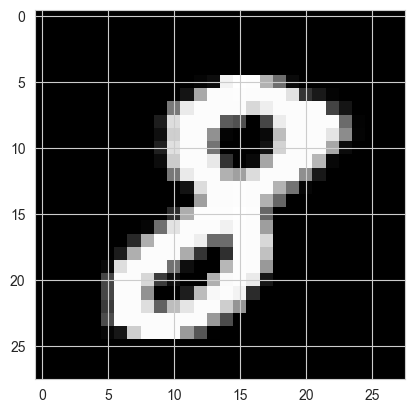

In [70]:
#plt.imshow(X_leaf_dict[18][leaf_samples_indices_mapping_inv[18][3]].squeeze(), cmap='gray')
plt.imshow(X[train_index_to_or_index[3]].squeeze(), cmap='gray')

## Plot the digits of all classes ending up in leaf 18 in the Hard Tree

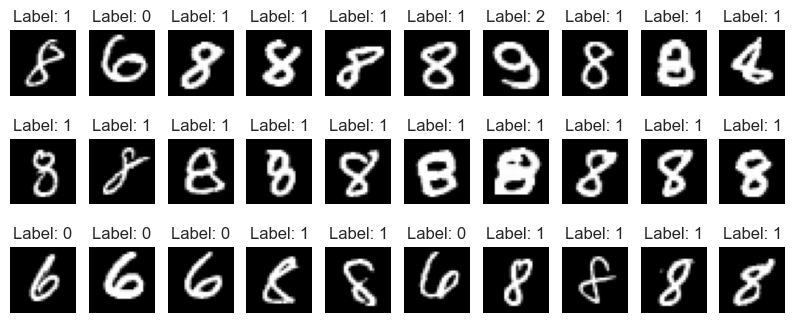

In [71]:
images = X_leaf_dict[18]
labels = y_leaf_dict[18]

# plot 100 digits in a grid of 5 digits per row
fig, ax = plt.subplots(3, 10, figsize=(10, 4))
for i in range(3):
    for j in range(10):
        ax[i, j].imshow(images[i * 10 + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f"Label: {labels[i * 10 + j]}")
        ax[i, j].axis('off')

### Find the samples in leaf 18 that have identical concepts but different classes

In [72]:
def find_unique_rows_and_indices(array):
    # Find unique rows and their counts
    unique_rows, counts = np.unique(array, axis=0, return_counts=True)
    
    # Find indices of each unique row
    indices = []
    for unique_row in unique_rows:
        row_indices = np.where((array == unique_row).all(axis=1))[0]
        indices.append(row_indices)
    
    return unique_rows, counts, indices

leaf_samples_indices_18 = leaf_samples_indices[18]
unique_rows, counts, indices = find_unique_rows_and_indices(C_leaf_dict[18])

# Isolate the rows that have column 7 equal to 1
mask = (unique_rows[:, 7] > 0.5)
unique_rows_width_xlarge = unique_rows[unique_rows[:, 7] > 0.5]
indices_width_xlarge = [idx for m, idx in zip(mask, indices) if m.all()]
counts_width_xlarge = counts[unique_rows[:, 7] > 0.5]
    

In [73]:
unique_rows_width_xlarge

array([[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]], dtype=float32)

In [74]:
# assign the class to each indice
class_indices = []
for idx in indices_width_xlarge:
    class_indices.append(y_leaf_dict[18][idx])

In [75]:
# assign the new_leaf id to each indice
new_leaf_indices = []
for indices in indices_width_xlarge:
    temp = []
    for idx in indices:
        for new_leaf, samples in new_leaves_per_leaf_samples_indices[18].items():
            if leaf_samples_indices_mapping[18][idx] in samples:
                temp.append(new_leaf)
    new_leaf_indices.append(np.array(temp))

In [76]:
new_leaf_indices

[array([5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 6, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 5,
        6, 5, 5, 6, 5, 6, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5,
        5, 6, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5,
        5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6,
        5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5,
        5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 6, 5,
        5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 6, 6, 6, 5, 5, 5, 5, 6,
        5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 6, 5, 6, 6, 6, 5, 5, 5, 5, 5, 6, 6,
        6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5]),
 array([4, 6, 6, 6, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4,
        6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4, 4, 4, 4, 6, 4, 6, 6,
        4, 6, 6, 4, 6, 4, 6, 4, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4

In [77]:
class_indices

[array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2,
        1, 1, 0, 0, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 2, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]),
 array([0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0

#### After observation, we see that the first and the third idx from array 2 satisfy the criteria: They have exactly the same concepts, but one ends up in leaf 4 being a 6, and the other ends up in leaf 6 being an 8

In [78]:
# Isolate these two samples
idx_1 = indices_width_xlarge[1][0]
idx_2 = indices_width_xlarge[1][2]

print(f"Index 1: {idx_1}, Class: {y_leaf_dict[18][idx_1]}")
print(f"Index 2: {idx_2}, Class: {y_leaf_dict[18][idx_2]}")
print(f"Concepts 1: {C_leaf_dict[18][idx_1]}")
print(f"Concepts 2: {C_leaf_dict[18][idx_2]}")

Index 1: 1, Class: 0
Index 2: 12, Class: 1
Concepts 1: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Concepts 2: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]


(-0.5, 27.5, 27.5, -0.5)

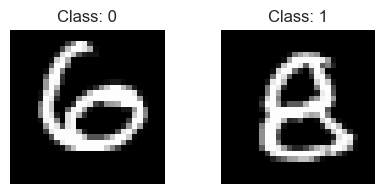

In [79]:
# plot the images
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax[0].imshow(X_leaf_dict[18][idx_1].squeeze(), cmap='gray')
ax[0].set_title(f"Class: {y_leaf_dict[18][idx_1]}")
ax[0].axis('off')

ax[1].imshow(X_leaf_dict[18][idx_2].squeeze(), cmap='gray')
ax[1].set_title(f"Class: {y_leaf_dict[18][idx_2]}")
ax[1].axis('off')


Original Index 1: 5114
Original Index 2: 9246


(-0.5, 27.5, 27.5, -0.5)

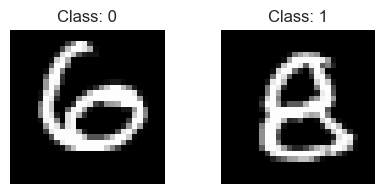

In [80]:
# retrieve the original indices
print(f"Original Index 1: {train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]}")
print(f"Original Index 2: {train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]}")

# sanity check: plot the images
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax[0].imshow(X[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]].squeeze(), cmap='gray')
ax[0].set_title(f"Class: {y[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]]}")
ax[0].axis('off')

ax[1].imshow(X[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]].squeeze(), cmap='gray')
ax[1].set_title(f"Class: {y[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]]}")
ax[1].axis('off')

In [81]:
# Print the true concepts
print(f"True Concepts 1: {targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]]}")
print(f"True Concepts 2: {targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]]}")

# Print the bins where the true concepts fall into
for i in range(targets.shape[1]):
    print(f"Feature {i}")
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[i]):
        if min_val is not None and max_val is not None:
            if min_val <= targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]][i] <= max_val:
                print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
            if min_val <= targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]][i] <= max_val:
                print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")

True Concepts 1: [ 2.49892932 18.56831308 60.50914498]
True Concepts 2: [ 2.46090624 16.10079244 63.96625176]
Feature 0
  Bin 3: Min = 2.455627281914512, Max = 2.901642846528742
  Bin 3: Min = 2.455627281914512, Max = 2.901642846528742
Feature 1
  Bin 4: Min = 14.53321565083615, Max = 21.116715020198313
  Bin 4: Min = 14.53321565083615, Max = 21.116715020198313
Feature 2
  Bin 4: Min = 54.47361107568206, Max = 93.52133829043453
  Bin 4: Min = 54.47361107568206, Max = 93.52133829043453


In [82]:
# Print the C_predicted_wit_sigmoid
print(f"Predicted Concept x_large: {C_leaf_pred_dict[18][idx_1][11]}")
print(f"Predicted Concept x_large: {C_leaf_pred_dict[18][idx_2][11]}")

Predicted Concept x_large: 0.9854037165641785
Predicted Concept x_large: 0.9993877410888672


### Collect all samples in leaf 18 having the concept 7 equal to 1

In [83]:
# Collect all samples in leaf 18 having the concept 7 equal to 1
indices = np.where(C_leaf_dict[18][:, 7] > 0.5)[0]
predictions = C_leaf_pred_dict[18][indices, 11]
prediction_indices = [i for i in range(len(predictions))]
indices_train = [leaf_samples_indices_mapping[18][idx] for idx in indices]
indices_all = [train_index_to_or_index[idx] for idx in indices_train]

# create a mapping from the prediction indices to the original indices
prediction_indices_mapping_inv = {indices_all[i]: idx for i, idx in enumerate(prediction_indices)}

data = {}
for idx, idx_or in zip(prediction_indices, indices_all):
    data[idx_or] = {}
    data[idx_or]["prediction"] = predictions[idx]
    data[idx_or]["true_value"] = targets[idx_or, 2]
    data[idx_or]["class"] = y[idx_or]
    
# sanity check
print(predictions[prediction_indices_mapping_inv[5114]])
print(predictions[prediction_indices_mapping_inv[9246]])

0.9854037
0.99938774


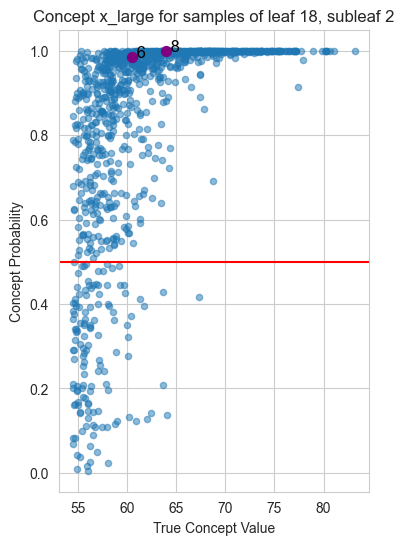

In [84]:
# make a scatter plot for the dictionary with the true values on the x-axis and the predictions on the y-axis
true_values = [data[idx]["true_value"] for idx in data]
predictions = [data[idx]["prediction"] for idx in data]
classes = [data[idx]["class"] for idx in data]

plt.figure(figsize=(4, 6))
plt.scatter(true_values, predictions, s=20, alpha=0.5)

# Highlight specific points
for idx in [5114, 9246]:
    plt.scatter(data[idx]["true_value"], data[idx]["prediction"], color='purple', s=50)  # Red dots for highlighted points
    plt.text(data[idx]["true_value"], data[idx]["prediction"], f' {class_index_to_name[data[idx]["class"]]}', color='black', fontsize=12)  # Class annotation

plt.xlabel("True Concept Value")
plt.ylabel("Concept Probability")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title("Concept x_large for samples of leaf 18, subleaf 2")
plt.show()


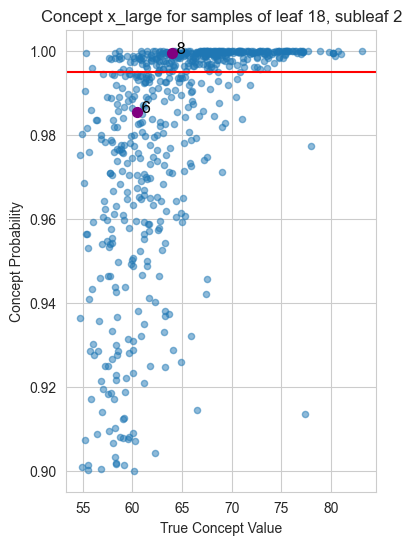

In [85]:
# make a scatter plot for the dictionary with the true values on the x-axis and the predictions on the y-axis
true_values = [data[idx]["true_value"] for idx in data if data[idx]["prediction"] > 0.9]
predictions = [data[idx]["prediction"] for idx in data if data[idx]["prediction"] > 0.9]
classes = [data[idx]["class"] for idx in data if data[idx]["prediction"] > 0.9]

plt.figure(figsize=(4, 6))
plt.scatter(true_values, predictions, s=20, alpha=0.5)

# Highlight specific points
for idx in [5114, 9246]:
    plt.scatter(data[idx]["true_value"], data[idx]["prediction"], color='purple', s=50)  # Red dots for highlighted points
    plt.text(data[idx]["true_value"], data[idx]["prediction"], f' {class_index_to_name[data[idx]["class"]]}', color='black', fontsize=12)  # Class annotation

plt.xlabel("True Concept Value")
plt.ylabel("Concept Probability")
plt.axhline(y=0.995, color='r', linestyle='-')
plt.title("Concept x_large for samples of leaf 18, subleaf 2")
plt.show()


## Make Box Plots

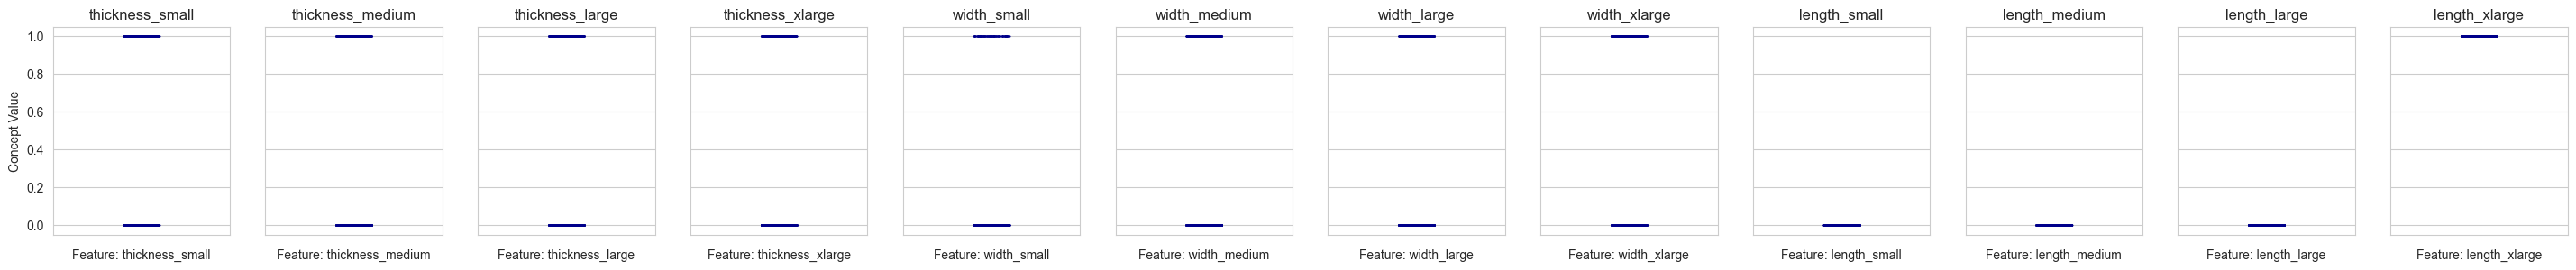

<Figure size 2000x1200 with 0 Axes>

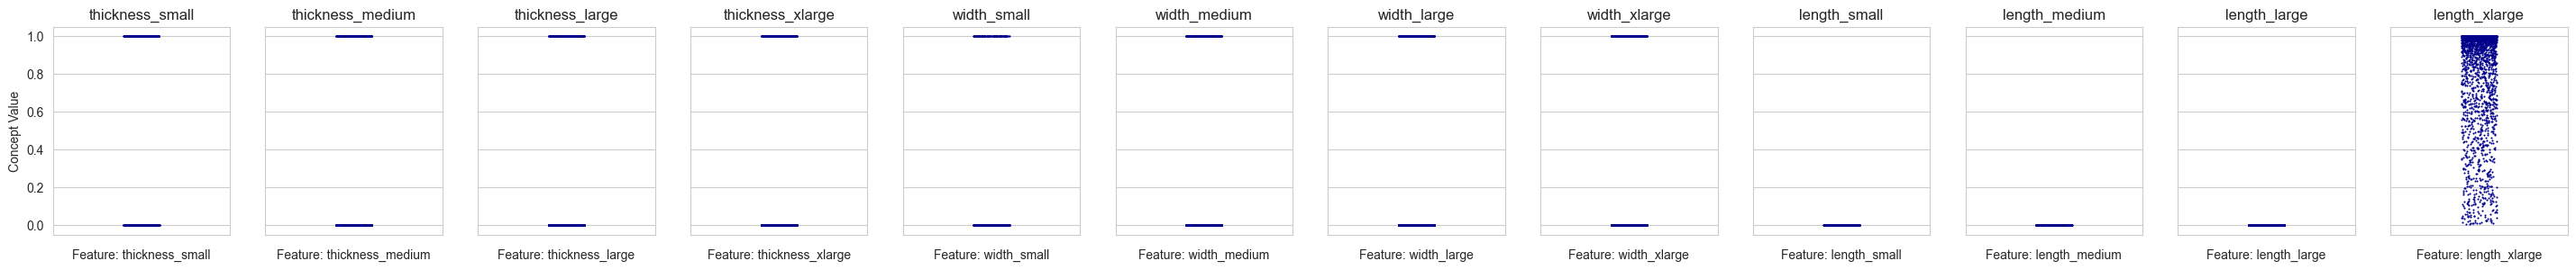

<Figure size 2000x1200 with 0 Axes>

In [28]:
def plot_boxplots_for_path(c, feature_names):

    fig, axs = plt.subplots(1, len(feature_names), figsize=(3*len(feature_names), 3), sharey=True)
    plt.figure(figsize=(20, len(feature_names)))
    
    for i in range(len(feature_names)):
        feature_index = i
        sns.stripplot(y=c[:, feature_index], ax=axs[i], color='darkblue', jitter=True, size=1.5)
        axs[i].set_title(f"{feature_names[i]}")
        axs[i].set_ylabel('Concept Value')
        axs[i].set_xlabel(f'Feature: {feature_names[i]}')
    plt.tight_layout()
    plt.show()
    
plot_boxplots_for_path(C_leaf_dict[18], feature_index_to_name)
plot_boxplots_for_path(C_leaf_pred_dict[18], feature_index_to_name)

# Repeat the same for the concepts of the joint CBM

In [37]:
output_path = "/Users/gouse/PycharmProjects/AR-Imperial-Thesis/saved/models/leakage_inspection/0906_161136/joint_CBM/train_dicts"

In [38]:
with open(os.path.join(output_path, 'leaf_samples_indices.pkl'), 'rb') as f:
    leaf_samples_indices = pkl.load(f)
with open(os.path.join(output_path, 'leaf_features_per_path.pkl'), 'rb') as f:
    leaf_features_per_path = pkl.load(f)
with open(os.path.join(output_path, 'new_leaves_per_leaf_samples_indices.pkl'), 'rb') as f:
    new_leaves_per_leaf_samples_indices = pkl.load(f)
with open(os.path.join(output_path, 'new_leaves_per_leaf_features_per_path.pkl'), 'rb') as f:
    new_leaves_per_leaf_features_per_path = pkl.load(f)
with open(os.path.join(output_path, 'C_leaf_pred_dict.pkl'), 'rb') as f:
    C_leaf_pred_dict = pkl.load(f)
with open(os.path.join(output_path, 'C_leaf_dict.pkl'), 'rb') as f:
    C_leaf_dict = pkl.load(f)
with open(os.path.join(output_path, 'y_leaf_dict.pkl'), 'rb') as f:
    y_leaf_dict = pkl.load(f)
with open(os.path.join(output_path, 'y_original_pred_dict.pkl'), 'rb') as f:
    y_original_pred_dict = pkl.load(f)
with open(os.path.join(output_path, 'y_pred_dict.pkl'), 'rb') as f:
    y_pred_dict = pkl.load(f)
with open(os.path.join(output_path, 'X_leaf_dict.pkl'), 'rb') as f:
    X_leaf_dict = pkl.load(f)

In [39]:
# map the leaf_samples_indices to a scaling from 0 to n_samples
leaf_samples_indices_mapping = {}
leaf_samples_indices_mapping_inv = {}
for leaf, samples in leaf_samples_indices.items():
    leaf_samples_indices_mapping[leaf] = {i : samples[i] for i in range(len(samples))}
    leaf_samples_indices_mapping_inv[leaf] = {samples[i]: i for i in range(len(samples))}

for leaf, new_leaves in new_leaves_per_leaf_samples_indices.items():
    for new_leaf, samples in new_leaves.items():
        for i in range(len(samples)):
            new_leaves_per_leaf_samples_indices[leaf][new_leaf][i] = leaf_samples_indices_mapping[leaf][samples[i]]

#### Sanity check: Plot digit with original index 3 in leaf 18

In [40]:
leaf_samples_indices_mapping_inv[18]

{0: 0,
 2: 1,
 3: 2,
 4: 3,
 14: 4,
 17: 5,
 23: 6,
 28: 7,
 29: 8,
 37: 9,
 51: 10,
 54: 11,
 57: 12,
 60: 13,
 61: 14,
 63: 15,
 66: 16,
 74: 17,
 80: 18,
 83: 19,
 84: 20,
 85: 21,
 87: 22,
 88: 23,
 93: 24,
 95: 25,
 102: 26,
 115: 27,
 120: 28,
 126: 29,
 127: 30,
 131: 31,
 133: 32,
 136: 33,
 137: 34,
 138: 35,
 146: 36,
 148: 37,
 151: 38,
 155: 39,
 156: 40,
 159: 41,
 160: 42,
 162: 43,
 165: 44,
 173: 45,
 174: 46,
 175: 47,
 177: 48,
 179: 49,
 180: 50,
 184: 51,
 191: 52,
 192: 53,
 201: 54,
 204: 55,
 207: 56,
 216: 57,
 224: 58,
 228: 59,
 232: 60,
 235: 61,
 254: 62,
 264: 63,
 269: 64,
 270: 65,
 276: 66,
 284: 67,
 290: 68,
 297: 69,
 298: 70,
 300: 71,
 303: 72,
 309: 73,
 314: 74,
 315: 75,
 316: 76,
 321: 77,
 326: 78,
 334: 79,
 347: 80,
 351: 81,
 353: 82,
 357: 83,
 361: 84,
 374: 85,
 375: 86,
 376: 87,
 383: 88,
 392: 89,
 399: 90,
 400: 91,
 402: 92,
 404: 93,
 406: 94,
 407: 95,
 410: 96,
 415: 97,
 428: 98,
 429: 99,
 431: 100,
 432: 101,
 434: 102,
 436: 1

In [42]:
new_leaves_per_leaf_samples_indices[18][3]

array([   2,   37,   85,   87,   95,  127,  137,  138,  148,  160,  204,
        235,  303,  404,  410,  415,  428,  452,  484,  492,  500,  505,
        516,  522,  530,  564,  577,  601,  607,  641,  644,  660,  681,
        690,  692,  733,  768,  791,  804,  820,  822,  840,  899,  928,
        940,  990, 1017, 1033, 1051, 1054, 1058, 1118, 1122, 1152, 1163,
       1166, 1192, 1208, 1211, 1218, 1235, 1241, 1296, 1356, 1386, 1387,
       1394, 1400, 1423, 1428, 1441, 1443, 1455, 1456, 1483, 1491, 1505,
       1509, 1523, 1546, 1550, 1625, 1634, 1660, 1665, 1672, 1702, 1703,
       1723, 1742, 1757, 1762, 1787, 1795, 1852, 1868, 1896, 1900, 1922,
       1958, 1964, 1966, 2003, 2005, 2022, 2034, 2042, 2054, 2106, 2111,
       2115, 2135, 2184, 2202, 2204, 2294, 2315, 2332, 2342, 2353, 2380,
       2393, 2396, 2403, 2418, 2419, 2443, 2520, 2525, 2530, 2558, 2569,
       2622, 2651, 2658, 2660, 2705, 2739, 2747, 2750, 2757, 2764, 2792,
       2812, 2813, 2817, 2822, 2825, 2902, 2927, 29

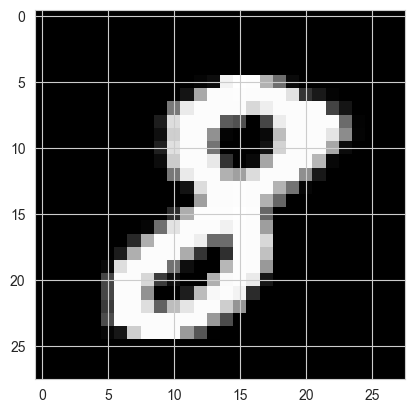

In [43]:
#plt.imshow(X_leaf_dict[18][leaf_samples_indices_mapping_inv[18][3]].squeeze(), cmap='gray')
plt.imshow(X[train_index_to_or_index[3]].squeeze(), cmap='gray')

## Plot the digits of all classes ending up in leaf 18 in the Hard Tree

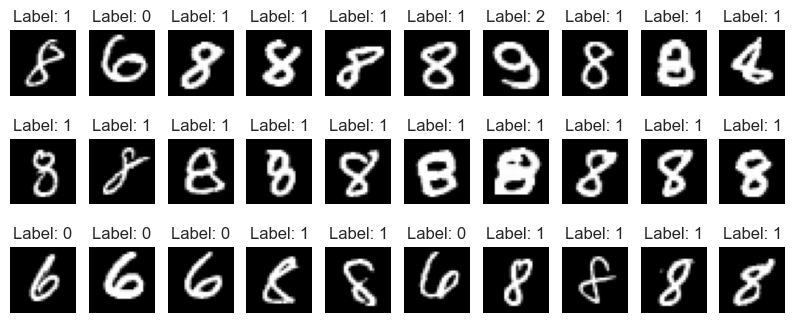

In [44]:
images = X_leaf_dict[18]
labels = y_leaf_dict[18]

# plot 100 digits in a grid of 5 digits per row
fig, ax = plt.subplots(3, 10, figsize=(10, 4))
for i in range(3):
    for j in range(10):
        ax[i, j].imshow(images[i * 10 + j].reshape(28, 28), cmap='gray')
        ax[i, j].set_title(f"Label: {labels[i * 10 + j]}")
        ax[i, j].axis('off')

### Find the samples in leaf 18 that have identical concepts but different classes

In [45]:
def find_unique_rows_and_indices(array):
    # Find unique rows and their counts
    unique_rows, counts = np.unique(array, axis=0, return_counts=True)
    
    # Find indices of each unique row
    indices = []
    for unique_row in unique_rows:
        row_indices = np.where((array == unique_row).all(axis=1))[0]
        indices.append(row_indices)
    
    return unique_rows, counts, indices

leaf_samples_indices_18 = leaf_samples_indices[18]
unique_rows, counts, indices = find_unique_rows_and_indices(C_leaf_dict[18])

# Isolate the rows that have column 7 equal to 1
mask = (unique_rows[:, 7] > 0.5)
unique_rows_width_xlarge = unique_rows[unique_rows[:, 7] > 0.5]
indices_width_xlarge = [idx for m, idx in zip(mask, indices) if m.all()]
counts_width_xlarge = counts[unique_rows[:, 7] > 0.5]
    

In [46]:
unique_rows_width_xlarge

array([[0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]], dtype=float32)

In [47]:
# assign the class to each indice
class_indices = []
for idx in indices_width_xlarge:
    class_indices.append(y_leaf_dict[18][idx])

In [48]:
# assign the new_leaf id to each indice
new_leaf_indices = []
for indices in indices_width_xlarge:
    temp = []
    for idx in indices:
        for new_leaf, samples in new_leaves_per_leaf_samples_indices[18].items():
            if leaf_samples_indices_mapping[18][idx] in samples:
                temp.append(new_leaf)
    new_leaf_indices.append(np.array(temp))

In [49]:
new_leaf_indices

[array([4, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 3, 4,
        3, 3, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4,
        3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4,
        4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 3, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4,
        4, 4, 3, 4, 4, 4, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 3, 3, 4, 3,
        4, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 3, 4,
        4, 3, 4, 4, 4, 4, 3, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3,
        4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,
        3, 4, 3, 4, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3]),
 array([3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
        4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 4, 4, 3, 4, 4,
        3, 4, 4, 4, 4, 3, 4, 3, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3

In [50]:
class_indices

[array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2,
        1, 1, 0, 0, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 2, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2,
        1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]),
 array([0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 1,
        2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0

#### After observation, we see that the first and the third idx from array 2 satisfy the criteria: They have exactly the same concepts, but one ends up in leaf 4 being a 6, and the other ends up in leaf 6 being an 8

In [51]:
# Isolate these two samples
idx_1 = indices_width_xlarge[1][0]
idx_2 = indices_width_xlarge[1][2]

print(f"Index 1: {idx_1}, Class: {y_leaf_dict[18][idx_1]}")
print(f"Index 2: {idx_2}, Class: {y_leaf_dict[18][idx_2]}")
print(f"Concepts 1: {C_leaf_dict[18][idx_1]}")
print(f"Concepts 2: {C_leaf_dict[18][idx_2]}")

Index 1: 1, Class: 0
Index 2: 12, Class: 1
Concepts 1: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Concepts 2: [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]


(-0.5, 27.5, 27.5, -0.5)

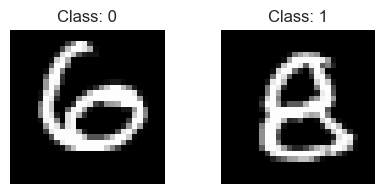

In [52]:
# plot the images
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax[0].imshow(X_leaf_dict[18][idx_1].squeeze(), cmap='gray')
ax[0].set_title(f"Class: {y_leaf_dict[18][idx_1]}")
ax[0].axis('off')

ax[1].imshow(X_leaf_dict[18][idx_2].squeeze(), cmap='gray')
ax[1].set_title(f"Class: {y_leaf_dict[18][idx_2]}")
ax[1].axis('off')


Original Index 1: 5114
Original Index 2: 9246


(-0.5, 27.5, 27.5, -0.5)

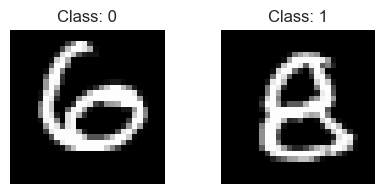

In [53]:
# retrieve the original indices
print(f"Original Index 1: {train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]}")
print(f"Original Index 2: {train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]}")

# sanity check: plot the images
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax[0].imshow(X[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]].squeeze(), cmap='gray')
ax[0].set_title(f"Class: {y[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]]}")
ax[0].axis('off')

ax[1].imshow(X[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]].squeeze(), cmap='gray')
ax[1].set_title(f"Class: {y[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]]}")
ax[1].axis('off')

In [54]:
# Print the true concepts
print(f"True Concepts 1: {targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]]}")
print(f"True Concepts 2: {targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]]}")

# Print the bins where the true concepts fall into
for i in range(targets.shape[1]):
    print(f"Feature {i}")
    for bin_idx, (min_val, max_val) in enumerate(min_max_values_all[i]):
        if min_val is not None and max_val is not None:
            if min_val <= targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_1]]][i] <= max_val:
                print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")
            if min_val <= targets[train_index_to_or_index[leaf_samples_indices_mapping[18][idx_2]]][i] <= max_val:
                print(f"  Bin {bin_idx + 1}: Min = {min_val}, Max = {max_val}")

True Concepts 1: [ 2.49892932 18.56831308 60.50914498]
True Concepts 2: [ 2.46090624 16.10079244 63.96625176]
Feature 0
  Bin 3: Min = 2.455627281914512, Max = 2.901642846528742
  Bin 3: Min = 2.455627281914512, Max = 2.901642846528742
Feature 1
  Bin 4: Min = 14.53321565083615, Max = 21.116715020198313
  Bin 4: Min = 14.53321565083615, Max = 21.116715020198313
Feature 2
  Bin 4: Min = 54.47361107568206, Max = 93.52133829043453
  Bin 4: Min = 54.47361107568206, Max = 93.52133829043453


In [55]:
# Print the C_predicted_wit_sigmoid
print(f"Predicted Concept x_large: {C_leaf_pred_dict[18][idx_1][11]}")
print(f"Predicted Concept x_large: {C_leaf_pred_dict[18][idx_2][11]}")

Predicted Concept x_large: 0.5
Predicted Concept x_large: 0.9560843706130981


### Collect all samples in leaf 18 having the concept 7 equal to 1

In [56]:
# Collect all samples in leaf 18 having the concept 7 equal to 1
indices = np.where(C_leaf_dict[18][:, 7] > 0.5)[0]
predictions = C_leaf_pred_dict[18][indices, 11]
prediction_indices = [i for i in range(len(predictions))]
indices_train = [leaf_samples_indices_mapping[18][idx] for idx in indices]
indices_all = [train_index_to_or_index[idx] for idx in indices_train]

# create a mapping from the prediction indices to the original indices
prediction_indices_mapping_inv = {indices_all[i]: idx for i, idx in enumerate(prediction_indices)}

data = {}
for idx, idx_or in zip(prediction_indices, indices_all):
    data[idx_or] = {}
    data[idx_or]["prediction"] = predictions[idx]
    data[idx_or]["true_value"] = targets[idx_or, 2]
    data[idx_or]["class"] = y[idx_or]
    
# sanity check
print(predictions[prediction_indices_mapping_inv[5114]])
print(predictions[prediction_indices_mapping_inv[9246]])

0.5
0.9560844


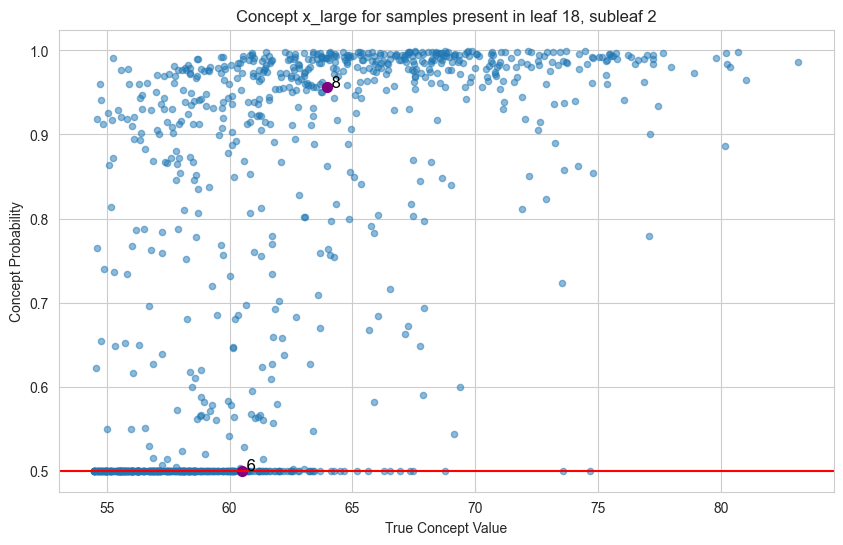

In [57]:
# make a scatter plot for the dictionary with the true values on the x-axis and the predictions on the y-axis
true_values = [data[idx]["true_value"] for idx in data]
predictions = [data[idx]["prediction"] for idx in data]
classes = [data[idx]["class"] for idx in data]

plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, s=20, alpha=0.5)

# Highlight specific points
for idx in [5114, 9246]:
    plt.scatter(data[idx]["true_value"], data[idx]["prediction"], color='purple', s=50)  # Red dots for highlighted points
    plt.text(data[idx]["true_value"], data[idx]["prediction"], f' {class_index_to_name[data[idx]["class"]]}', color='black', fontsize=12)  # Class annotation

plt.xlabel("True Concept Value")
plt.ylabel("Concept Probability")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title("Concept x_large for samples present in leaf 18, subleaf 2")
plt.show()


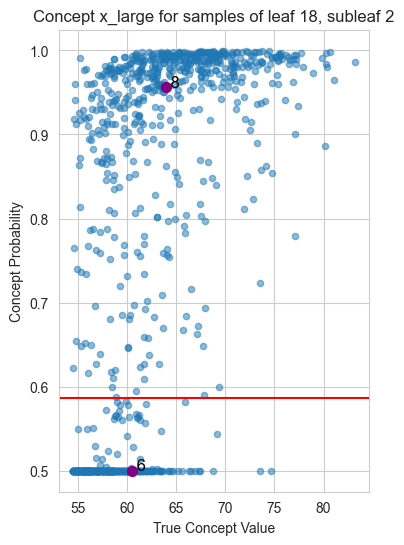

In [64]:
# make a scatter plot for the dictionary with the true values on the x-axis and the predictions on the y-axis
true_values = [data[idx]["true_value"] for idx in data if data[idx]["prediction"] >= 0.5]
predictions = [data[idx]["prediction"] for idx in data if data[idx]["prediction"] >= 0.5]
classes = [data[idx]["class"] for idx in data if data[idx]["prediction"] >= 0.5]

plt.figure(figsize=(4, 6))
plt.scatter(true_values, predictions, s=20, alpha=0.5)

# Highlight specific points
for idx in [5114, 9246]:
    plt.scatter(data[idx]["true_value"], data[idx]["prediction"], color='purple', s=50)  # Red dots for highlighted points
    plt.text(data[idx]["true_value"], data[idx]["prediction"], f' {class_index_to_name[data[idx]["class"]]}', color='black', fontsize=12)  # Class annotation

plt.xlabel("True Concept Value")
plt.ylabel("Concept Probability")
plt.axhline(y=0.587, color='r', linestyle='-')
plt.title("Concept x_large for samples of leaf 18, subleaf 2")
plt.show()
